In [1]:
import pybullet as p
import pybullet_data
import math
import time
import  matplotlib.pyplot as plt
import numpy as np

In [2]:
physicsClient = p.connect(p.GUI)#or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #used by loadURDF

In [3]:
p.setGravity(0,0,-9.8)
planeId = p.loadURDF("plane.urdf")

In [4]:
# cubeStartPos = [0,0,0]
cubeStartPos = [0,0,0]
cubeStartOrientation = p.getQuaternionFromEuler([3*math.pi/2,0,0])
boxId = p.loadURDF("C:/ZHR/robotcontrol/NACHI/NACHI1/nachi.urdf",cubeStartPos, cubeStartOrientation,useFixedBase=True)

In [5]:
cubeStartPosxfd = [0.6,0,0.3]
cubeStartOrientationxfd = p.getQuaternionFromEuler([0,0,0])
xfdId = p.loadURDF("C:/ZHR/robotcontrol/NACHI/xfd/urdf/xfd.urdf",cubeStartPosxfd, cubeStartOrientationxfd,useFixedBase=True)

In [6]:
cubeStartPosgzt = [0.6,0,0]
cubeStartOrientationgzt = p.getQuaternionFromEuler([0,0,0])
gztId = p.loadURDF("C:/ZHR/robotcontrol/NACHI/gzt/urdf/gzt.urdf",cubeStartPosgzt, cubeStartOrientationgzt,useFixedBase=True)

In [7]:
print(p.getDynamicsInfo(xfdId,-1),'\n')
print(p.getDynamicsInfo(boxId,-1),'\n')

(0.0, 0.5, (0.0, 0.0, 0.0), (1.0310988315208252e-16, 0.0024999999441206455, -3.570639265009676e-17), (0.0, 0.0, 0.0, 1.0), 0.0, 0.0, 0.0, -1.0, -1.0) 

(0.0, 0.5, (0.0, 0.0, 0.0), (-0.04471199959516525, -0.08581899851560593, -3.1194998882710934e-05), (0.0, 0.0, 0.0, 1.0), 0.0, 0.0, 0.0, -1.0, -1.0) 



In [8]:
def TargetPosition(t):
    if t<1:
        pos=0.625-0.5*0.05*t**2
    elif t<=3:
        pos=0.6-0.05*(t-1)
    elif t<=4:
        pos=0.5-0.05*(t-3)+0.5*0.05*(t-3)**2
    else:
        pos=0.467
    return pos

In [9]:
class ImpedanceControl:
    def __init__(self):
        self.Md = 0
        self.Bd = 0
        self.Kd = 0
        self.Initialize()
    def Initialize(self):
        #set time variable
        import time
        self.currtm = time.time()
        self.prevtm = self.currtm
        NoT = 0  #number of cycle
    def SetMd(self,MdInput):
        self.Md = MdInput
    def SetBd(self,BdInput):
        self.Bd = BdInput
    def SetKd(self,KdInput):
        self.Kd = KdInput
    def GenOut(self,PPerror,Perror,Cerror,PPdeltaX,PdeltaX):
        Omega1 = 4*self.Md + 2*self.Bd*T + self.Kd*(T**2)
        Omega2 = -8*self.Md + 2*self.Kd*(T**2)
        Omega3 = 4*self.Md - 2*self.Bd*T + self.Kd*(T**2)
        if NoT == 1:
            return T**2 / Omega1 * Cerror
        elif NoT == 2:
            return T**2 / Omega1 * (Cerror + 2*Perror) - Omega2/Omega1*PdeltaX
        else:
            return T**2 / Omega1 *(Cerror + 2*Perror + PPerror) - (Omega2/Omega1)*PdeltaX - (Omega3/Omega1)*PPdeltaX

In [10]:
print(p.getNumJoints(boxId))
print(boxId)
# 查看关节信息
p.setRealTimeSimulation(1)
for i in range(p.getNumJoints(boxId)):
   print(p.getJointState(boxId, i),'\n')
   p.setJointMotorControl2(boxId, i, p.POSITION_CONTROL, targetPosition=0, force=2000)
p.setRealTimeSimulation(0)

6
1
(0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0) 

(0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0) 

(0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0) 

(0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0) 

(0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0) 

(0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0) 



In [11]:
# p.changeDynamics(xfdId,-1,contactStiffness=10000,contactDamping=100)
# print(p.getDynamicsInfo(xfdId,-1),'\n')
# print(p.getDynamicsInfo(boxId,-1),'\n')

In [12]:
# p.setJointMotorControl2(boxId,4,controlMode=p.VELOCITY_CONTROL,targetVelocity=0.1,force=1000)
# p.setJointMotorControl2(boxId,2,controlMode=p.POSITION_CONTROL,targetPosition=math.pi/4,force=2000)
# p.setJointMotorControl2(boxId,4,controlMode=p.POSITION_CONTROL,targetPosition=-math.pi/4,force=2000)

In [13]:
# print(p.getLinkState(boxId,5)[0])

In [14]:
#创建实例
IC = ImpedanceControl()
#设置阻抗控制参数
IC.SetMd(1)    
IC.SetBd(800)  
IC.SetKd(1000) 
# 阻抗控制器工作频率100Hz
T = 0.01
#Ke = 20    #stiffness of the environment

pperror,perror = 0,0
deltax,pdeltax,ppdeltax = 0,0,0
Fd=6
NoT=0

In [15]:
jd=[0.5,0.5,0.5,0.5,0.5,0.5,0.5]  #Using large values for the joints that we don't want to move. eg：jd=[100.0,100.0,100.0,100.0,100.0,100.0,0.5]
# 初始位姿
pos = [0.352,0,0.625]
orn = p.getQuaternionFromEuler([0,0,0])
J5P = 0
#安装力传感器
p.enableJointForceTorqueSensor(boxId,5)
# x方向力的记录
Fz1 = []
TT=[]
TarPos=[]
ActPos=[]
# 仿真
# p.setTimeStep(0.001)
ContactForce = 0
t=0
p.setRealTimeSimulation(1)
for i in range(1000):
#     p.stepSimulation()
    pos[2] = TargetPosition(t)-deltax
    TT.append(t)
    TarPos.append(pos[2])
    jointPoses = p.calculateInverseKinematics(boxId,5,pos,orn,jointDamping=jd)
    p.setJointMotorControlArray(boxId,[0,1,2,3,4,5],controlMode=p.POSITION_CONTROL,targetPositions=jointPoses,
                                targetVelocities=[0,0,0,0,0,0],forces=[1000,1000,1000,1000,1000,1000],
                               positionGains=[0.03,0.03,0.03,0.03,0.03,0.03],
                               velocityGains=[1,1,1,1,1,1])
    J5EndState=p.getJointState(boxId,jointIndex=5)    # output: (1)jointPosition ; (2)jointVelocity ; (3)jointReactionForces (4)appliedJointMotorTorque
    Fz1.append(-J5EndState[2][2])     #get F in x-axis
    t += T
    ContactForce = -J5EndState[2][2]
    ActPos.append(p.getLinkState(boxId,5)[0][2])
    
    if ContactForce > 0:       #接触后便恒力跟踪
        error = Fd-ContactForce  # + - ???
        deltax = IC.GenOut(PPerror=pperror,Perror=perror,Cerror=error,PPdeltaX=ppdeltax,PdeltaX=pdeltax)
        # prepare for next loop
        ppdeltax = pdeltax
        pdeltax = deltax
        pperror = perror
        perror = error   
    else:
        deltax = 0              
    NoT+=1
    time.sleep(T)
p.setRealTimeSimulation(0)

In [16]:
# print(p.getLinkState(boxId,5)[0])

In [17]:
# for i in range(p.getNumJoints(boxId)):
#    print(p.getJointState(boxId, i),'\n')

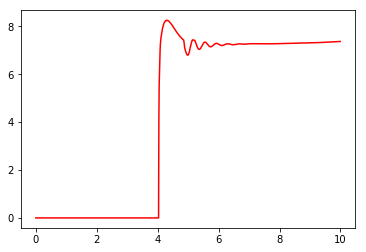

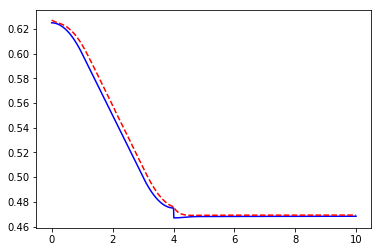

In [18]:
x=TT
y = Fz1
plt.plot(x, y, 'r-')
plt.show()
plt.plot(x, TarPos, 'b-',x,ActPos,'r--')
plt.show()

In [19]:
# time.sleep(0.03)
p.disconnect()